<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/image_segmentation/transformer_seg_traiining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI image segmentation with SegFormer

Train a deep-learning-based semantic segmentation transformer model to identify the tumor locations and boundaries within MRI brain images, using brain images and coresponding ground truth masks. Pnce trained, SegFormer can predict bounderies of tumor regions. A segmentation accuracy metric Mean IoU is appliced to asses model quality.

In [ ]:
!pip install jedi

In [ ]:
!apt-get install libcairo2-dev pkg-config python3-dev

In [ ]:
!pip install pycairo

In [ ]:
!pip install --upgrade fsspec==2024.10.0

In [ ]:
!pip install datasets transformers

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


In [9]:
!ls

data_preproces.ipynb  mri_data_seg  segmentation_dataset  transformer_seg_traiining.ipynb


## 1. Load MRI dataset

The dataset is a dictionary containg the images and coresponding masks, split into train, test and validate datasets.

In [10]:
from datasets import load_from_disk

dataset = load_from_disk("segmentation_dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 200
    })
    validate: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 100
    })
})

## 2. Training Function

### Load Hugging Face SegFormer model

In [38]:
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# SegformerForSemanticSegmentation model is not competable with 2-class segmentation task
from transformers import SegformerForSemanticSegmentation
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def list_and_set_gpu_memory_growth():
    """
    Lists available GPUs and sets memory growth for each GPU.
    """

    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"GPU {i}: {gpu_properties.name}")

            # Enable memory growth for this GPU
            torch.cuda.set_per_process_memory_fraction(1.0, device=i)
            #torch.cuda.empty_cache()

            # Check if memory growth is enabled (optional)
            #is_memory_growth_enabled = torch.cuda.is_memory_growth_enabled(i)  # PyTorch 2.0+
            #print(f"  Memory growth enabled: {is_memory_growth_enabled}")
    else:
        print("CUDA is not available.")

# Call the function to list and set memory growth
list_and_set_gpu_memory_growth()

# initialize the model
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
# load the SegformaerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels = 2,
    id2label = {0: 'background', 1: 'tumor'},
    label2id = {'background': 0, 'tumor': 1},
    ignore_mismatched_sizes = True
)

# set hyperparameters for training
batch_size = 2
num_epochs = 25
num_training_steps = (len(dataset['train'])//batch_size) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

# compile the model
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=learning_rate,
                              weight_decay=weight_decay_rate)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

criterion = torch.nn.CrossEntropyLoss()

Number of available GPUs: 1
GPU 0: Tesla T4


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set up training arguments for initializing hyperparameters

In [12]:
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 2

# define a transform to convert PIL images to PyTorch tensors
transform = transforms.Compose([
    # convert PIL image to PyTorch tensor
    transforms.ToTensor(),  # convert PIL image to PyTorch tensor
])

def process_train_batch(batch):
  """ Read an bath of train images and transform them into inputs.
      Since transformer is pre-trained on RGB images convert from gray scale"""

  batch_imgs = [transform(img.convert("RGB")) for img in batch['pixel_values']]
  batch_masks = [transform(mask.convert("L")) for mask in batch['label']]

  # return a dictionary with image and label data
  return {'pixel_values': batch_imgs, 'mask': batch_masks}

def process_val_batch(batch):
  """ Read an bath of test images and transform them into inputs. """
  batch_imgs = [transform(img.convert("RGB")) for img in batch['pixel_values']]
  batch_masks = [transform(label.convert("L")) for label in batch['label']]

  # return a dictionary with image and label data
  return {'pixel_values': batch_imgs, 'mask': batch_masks}

dataset["train"].set_transform(process_train_batch)
dataset["test"].set_transform(process_train_batch)
dataset["validate"].set_transform(process_val_batch)

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset['validate'], batch_size=batch_size, shuffle=True)


for batch in train_loader:
  # convert each gray scale image in batch to RGB

  print(f"batch data type: {type(batch)}")
  print(f"batch images size: {batch['pixel_values'].shape}")
  print(f"batch masks size: {batch['mask'].shape}")
  print()
  image = batch['pixel_values'][0]
  mask = batch['mask'][0]
  print(f"image dimensions: {image.size}")
  print(f"image data type: {image.dtype}")
  print(f"image min value: {image.min()}")
  print(f"image max value: {image.max()}")
  print(f"labels in mask:, {np.unique(mask)}")
  print(f"mask dimensions: {mask.size}")
  print(f"mask data type: {mask.dtype}")
  print(f"mask min value: {mask.min()}")
  print(f"mask max value: {mask.max()}")
  print()
  break

batch data type: <class 'dict'>
batch images size: torch.Size([2, 3, 512, 512])
batch masks size: torch.Size([2, 1, 512, 512])

image dimensions: <built-in method size of Tensor object at 0x7fe97806c890>
image data type: torch.float32
image min value: 0.0
image max value: 1.0
labels in mask:, [0. 1.]
mask dimensions: <built-in method size of Tensor object at 0x7fe97806ca10>
mask data type: torch.float32
mask min value: 0.0
mask max value: 1.0



## 3. Accuracy Estimation

In [13]:
def calculate_iou(true_class, pred_class):
    """
    Calculate Intersection over Union (IoU) for a specific class.
    Args:
        true_class (torch.Tensor): Boolean mask for the true class.
        pred_class (torch.Tensor): Boolean mask for the predicted class.
    Returns:
        float: IoU score for the class.
    """

    intersection = torch.logical_and(true_class, pred_class)
    union = torch.logical_or(true_class, pred_class)

    if torch.any(union):
        iou = torch.sum(intersection).float() / torch.sum(union).float()
    else:
        iou = 0.0  # if no overlap
    #print(f"IoU: {iou}")
    #print()
    return iou


def calculate_mean_iou(true_mask, pred_mask):
    """
    Calculate the mean Intersection over Union (mIoU) score.
    Args:
        true_mask (torch.Tensor): Ground truth mask.
        pred_mask (torch.Tensor): Predicted mask.
    Returns:
        float: Mean IoU score across all classes.
    """

    #class_iou = []

    # Get the maximum class value (assuming contiguous classes starting from 0)
    #max_value = true_mask.max().item()
    #print(f"Max class value: {max_value}")

    #for i in range(1, max_value + 1):  # Skip background (class 0)
        #true_i = (true_mask == i)
        #pred_i = (pred_mask == i)
        #print(f"Class {i}: true_i sum: {torch.sum(true_i)}, pred_i sum: {torch.sum(pred_i)}")

        #iou = calculate_iou(true_i, pred_i)
        #print(f"Class {i} IoU: {iou}")
        #class_iou.append(iou)

    # Compute the mean IoU
    #if class_iou:
        #mean_iou = torch.mean(torch.tensor(class_iou))
    #else:
        #mean_iou = 0.0  # Handle case with no classes
        #print(f"Mean IoU: {mean_iou}")

    intersection = torch.logical_and(true_mask, pred_mask)
    union = torch.logical_or(true_mask, pred_mask)

    if torch.any(union):
        mean_iou = torch.sum(intersection).float() / torch.sum(union).float()
    else:
        mean_iou = 0.0  # if no overlap

    print(f"Mean IoU: {mean_iou}")

    return mean_iou


## 4. Callback Function

In [47]:
def create_mask(pred_logits, target_size):
    """Create a mask from model logits."""

    # resize logits to match the ground truth size
    pred_logits_resized = F.interpolate(
        pred_logits,
        size=target_size,
        mode='bilinear',
        align_corners=False
    )

    class_0_logits = pred_logits_resized[:, 0, :, :]
    class_1_logits = pred_logits_resized[:, 1, :, :]

    print(f"Class 0 logits: mean={class_0_logits.mean()}, min={class_0_logits.min()}, max={class_0_logits.max()}")
    print(f"Class 1 logits: mean={class_1_logits.mean()}, min={class_1_logits.min()}, max={class_1_logits.max()}")


    #for i in range(pred_logits_resized.shape[1]):
      #print(f"Class {i} logits mean: {pred_logits[:, i, :, :].mean().item()}, max: {pred_logits[:, i, :, :].max().item()}")


    #plt.figure(figsize=(10, 5))
    #plt.subplot(1, 2, 1)
    #plt.imshow(class_0_logits[0].cpu().detach().numpy(), cmap="jet")
    #plt.title("Class 0 Logits")
    #plt.colorbar()

    #plt.subplot(1, 2, 2)
    #plt.imshow(class_1_logits[0].cpu().detach().numpy(), cmap="jet")
    #plt.title("Class 1 Logits")
    #plt.colorbar()

    #plt.show()

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # argmax zeros all pred_mask values
    print(f"predicted logits dims: {pred_logits_resized.shape}")
    pred_mask = torch.argmax(pred_logits_resized, dim=1)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    print(f"Predicted mask: min={pred_mask.min()}, max={pred_mask.max()}")
    print(f"Predicted mask unique values: {torch.unique(pred_mask)}")

    return pred_mask

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(image, ground_truth_mask, predicted_mask):
    """
    Display the input image, ground truth mask, and predicted mask side by side.

    Args:
        image (torch.Tensor): The input image tensor (C, H, W).
        ground_truth_mask (torch.Tensor): The ground truth mask tensor (H, W).
        predicted_mask (torch.Tensor): The predicted mask tensor (H, W).
    """
    # Move the image and masks to the CPU and convert to NumPy
    image = image.cpu().numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    ground_truth_mask = ground_truth_mask.cpu().numpy()

    ground_truth_mask = ground_truth_mask[0]

    # Select the first channel of the ground_truth_mask to display it as grayscale
    # ground_truth_mask = ground_truth_mask[0]
    #if predicted_mask is not None:

    predicted_mask = predicted_mask.cpu().numpy()

    # Normalize the image for display (optional: adjust depending on input range)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(ground_truth_mask, cmap="jet") # select the first channel
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")


    #if predicted_mask is not None:
    axs[2].imshow(predicted_mask, cmap="jet")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


In [40]:
@torch.no_grad()
def custom_callback(epoch, model, val_loader, device):
    """
    Callback function executed after each training epoch.
    Evaluates the model on the validation set and calculates mean IoU.
    """
    model.eval()
    print(f"Running validation for epoch {epoch + 1}...")

    total_mean_iou = 0.0
    num_batches = 0

    for batch in val_loader:
        pixel_values = batch['pixel_values'].to(device)
        true_mask = torch.argmax(batch['mask'].to(device), dim=1)

        # Get model predictions
        outputs = model(pixel_values)
        pred_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])

        # Compute mean IoU for the batch
        mean_iou = calculate_mean_iou(true_mask, pred_mask)
        total_mean_iou += mean_iou
        num_batches += 1

    avg_mean_iou = total_mean_iou / num_batches
    print(f"Epoch {epoch + 1}: Mean IoU: {avg_mean_iou:.4f}")


    #print(f"Unique values in ground truth mask (batch): {torch.unique(batch['mask'])}")
    #print(f"Unique values in ground truth mask (per image): {torch.unique(true_mask[0])}")

    display_image(
        image=pixel_values[0],  # First image in the batch
        ground_truth_mask=true_mask[0],  # Ground truth mask for the first image
        predicted_mask=pred_mask[0]  # Predicted mask for the first image
      )


## 5. Run Training

In [41]:
import torch
import torch.nn.functional as F  # for the interpolate function

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, custom_callback):
    """
    Trains the given model on the provided training data and displays predictions on validation data after each epoch.

    Args:
        model: The model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function.
        num_epochs: Number of training epochs.
        device: Device to use for computation ('cuda' or 'cpu').
        custom_callback: Callback function to execute after each epoch.
    """
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_loader:
            # Move the pixel_values and label tensors to the device
            pixel_values = batch['pixel_values'].to(device)
            labels = torch.argmax(batch['mask'].to(device), dim=1).long()

            optimizer.zero_grad()
            outputs = model(pixel_values)

            # Resize model outputs to match the input image size
            outputs_resized = F.interpolate(
                outputs.logits,
                size=labels.shape[1:],  # match height and width of labels
                mode='bilinear',
                align_corners=False
            )

            # Compute the loss
            loss = criterion(outputs_resized, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

        # Execute the custom callback function after each epoch
        #custom_callback(epoch, model, val_loader, device)


In [42]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, custom_callback)

Epoch [1/25], Average Loss: 0.4703
Epoch [2/25], Average Loss: 0.1728
Epoch [3/25], Average Loss: 0.0911
Epoch [4/25], Average Loss: 0.0561
Epoch [5/25], Average Loss: 0.0390
Epoch [6/25], Average Loss: 0.0289
Epoch [7/25], Average Loss: 0.0221
Epoch [8/25], Average Loss: 0.0175
Epoch [9/25], Average Loss: 0.0142
Epoch [10/25], Average Loss: 0.0119
Epoch [11/25], Average Loss: 0.0099
Epoch [12/25], Average Loss: 0.0083
Epoch [13/25], Average Loss: 0.0073
Epoch [14/25], Average Loss: 0.0063
Epoch [15/25], Average Loss: 0.0056
Epoch [16/25], Average Loss: 0.0049
Epoch [17/25], Average Loss: 0.0043
Epoch [18/25], Average Loss: 0.0039
Epoch [19/25], Average Loss: 0.0035
Epoch [20/25], Average Loss: 0.0031
Epoch [21/25], Average Loss: 0.0029
Epoch [22/25], Average Loss: 0.0026
Epoch [23/25], Average Loss: 0.0024
Epoch [24/25], Average Loss: 0.0021
Epoch [25/25], Average Loss: 0.0020


In [44]:
# save model weigths
model.save_pretrained("segformer_tumor_segmentation")

# load trained model weigths
trained_model = SegformerForSemanticSegmentation.from_pretrained("segformer_tumor_segmentation")

In [ ]:
import torch
import torch.nn.functional as F

def evaluate_model(model, train_loader, device):
    """
    Evaluates the model on the training dataset and computes the Mean IoU.

    Args:
        model: The trained model.
        train_loader: DataLoader for the training data.
        device: Device to use for computation ('cuda' or 'cpu').

    Returns:
        float: The average Mean IoU score across the training dataset.
    """
    model.eval()  # Set the model to evaluation mode
    # Move the model to the specified device
    model.to(device)

    total_mean_iou = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for batch in train_loader:
            pixel_values = batch['pixel_values'].to(device)
            true_mask = torch.argmax(batch['mask'].to(device), dim=1)  # Ground truth mask

            # Get model predictions
            outputs = model(pixel_values)
            pred_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])  # Predicted mask

            # Compute mean IoU for the batch
            mean_iou = calculate_mean_iou(true_mask, pred_mask)
            total_mean_iou += mean_iou
            num_batches += 1

    avg_mean_iou = total_mean_iou / num_batches
    print(f"Training dataset: Mean IoU: {avg_mean_iou:.4f}")

    return avg_mean_iou

# After training the model:
train_mean_iou = evaluate_model(trained_model, train_loader, device)

In [ ]:
import matplotlib.pyplot as plt

def debug_visualize(image, true_mask, pred_mask):
    image = image.cpu().numpy().transpose(1, 2, 0)
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="jet")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

Class 0 logits: mean=1.37789785861969, min=0.605682373046875, max=2.0534169673919678
Class 1 logits: mean=-1.1775726079940796, min=-1.897944450378418, max=-0.3571290373802185


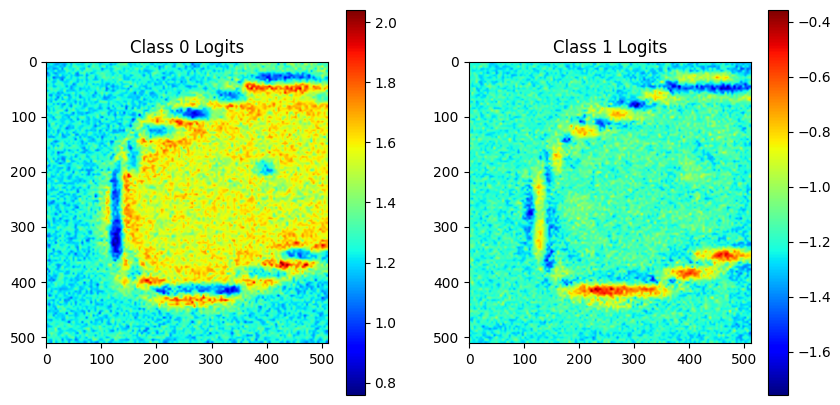

predicted logits dims: torch.Size([2, 2, 512, 512])
Predicted mask unique values: tensor([0], device='cuda:0')
torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
torch.Size([2, 512, 512])


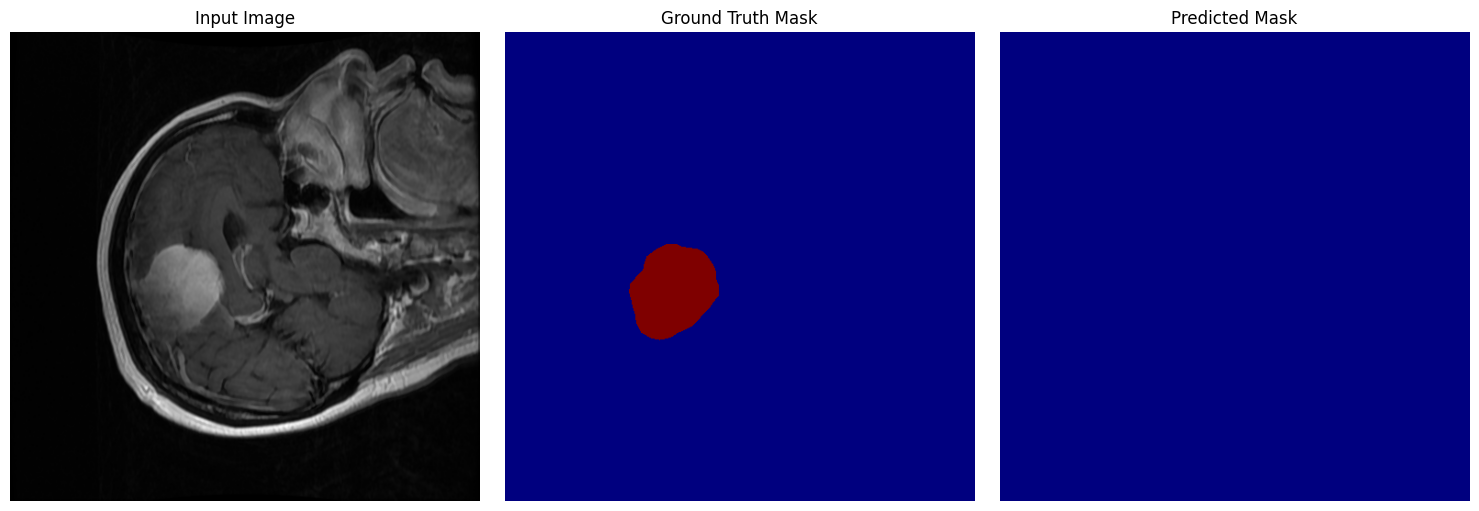

In [28]:
output = model(batch['pixel_values'].to(device))

pred_mask = create_mask(output.logits, target_size=batch['mask'].shape[-2:])

print(batch['pixel_values'][0].shape)
print(batch['mask'][0].shape)
print(pred_mask.shape)
display_image(
    image=batch['pixel_values'][0],
    ground_truth_mask=batch['mask'][0],
    predicted_mask=pred_mask[0]
)

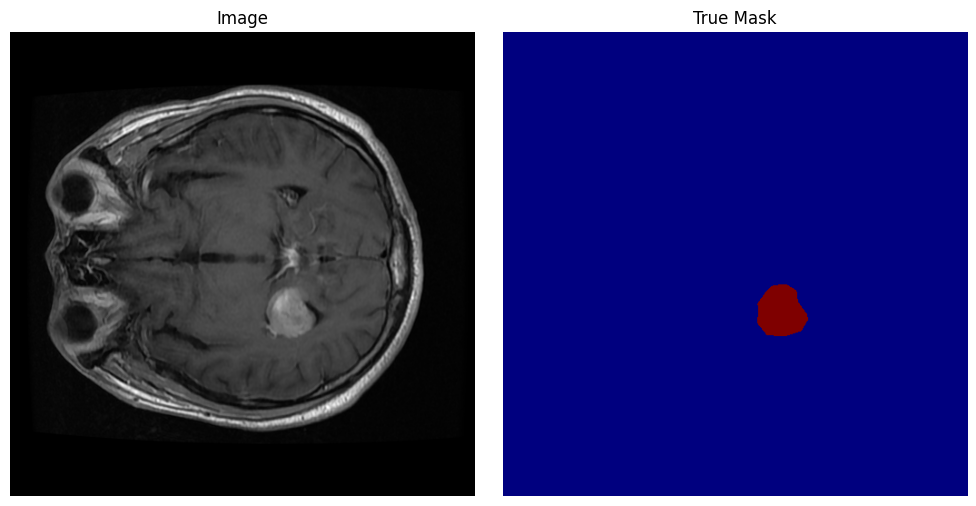

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_and_mask(image, mask):
    """
    Displays an image and its corresponding mask.

    Args:
        image (torch.Tensor): The image tensor (C, H, W).
        mask (torch.Tensor): The mask tensor (H, W).
    """

    # Move tensors to CPU and convert to NumPy arrays
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    mask = mask.cpu().numpy()

    # Normalize the image for display
    image = (image - image.min()) / (image.max() - image.min())

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    # Display the mask
    axs[1].imshow(mask, cmap="jet")  # Use a suitable colormap for the mask
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Get a batch from the validation loader
for batch in val_loader:
    break  # Get only the first batch

# Access the image and mask from the batch
image = batch['pixel_values'][0]  # Get the first image from the batch
true_mask = batch['mask'][0].squeeze(0)  # Get the first mask and remove channel dimension if necessary


# Display the image and mask
display_image_and_mask(image, true_mask)

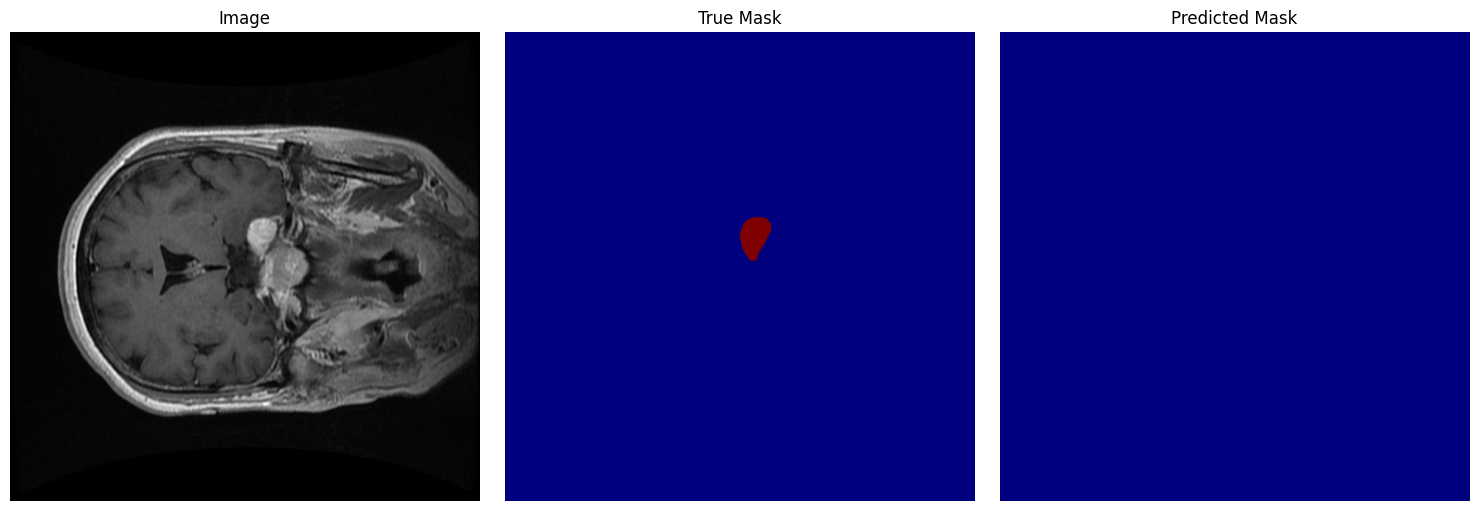

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image_and_masks(image, true_mask, predicted_mask):
    """
    Displays an image, its true mask, and the predicted mask.

    Args:
        image (torch.Tensor): The image tensor (C, H, W).
        true_mask (torch.Tensor): The true mask tensor (H, W).
        predicted_mask (torch.Tensor): The predicted mask tensor (H, W).
    """

    # Move tensors to CPU and convert to NumPy arrays
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    true_mask = true_mask.cpu().numpy()
    predicted_mask = predicted_mask.cpu().numpy()

    # Normalize the image for display
    image = (image - image.min()) / (image.max() - image.min())

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    # Display the true mask
    axs[1].imshow(true_mask, cmap="jet")
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    # Display the predicted mask
    axs[2].imshow(predicted_mask.squeeze(0), cmap="jet")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# Get a batch from the validation loader
for batch in val_loader:
    break  # Get only the first batch

# Get the image and true mask from the batch
image = batch['pixel_values'][0].to(device)  # Move image to device
true_mask = batch['mask'][0].squeeze(0).to(device)  # Move mask to device and squeeze if necessary

# Get model prediction
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image.unsqueeze(0))  # Add batch dimension for single image
    predicted_mask = torch.argmax(outputs.logits, dim=1)  # Get predicted mask

    # Resize predicted mask to match true mask dimensions - **Corrected**
    predicted_mask = torch.nn.functional.interpolate(
        predicted_mask.unsqueeze(1).float(),
        size=true_mask.shape[-2:],  # Use only the spatial dimensions (H, W)
        mode='nearest'
    ).squeeze(1).long()


# Display the image, true mask, and predicted mask
display_image_and_masks(image.cpu(), true_mask.cpu(), predicted_mask.cpu())

In [22]:
print(image.shape)
print(true_mask.shape)
print(predicted_mask.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])
torch.Size([1, 512, 512])


Class 0 logits: mean=1.3725736141204834, min=0.7868449687957764, max=2.21016001701355
Class 1 logits: mean=-1.1693525314331055, min=-1.8401355743408203, max=-0.5427481532096863


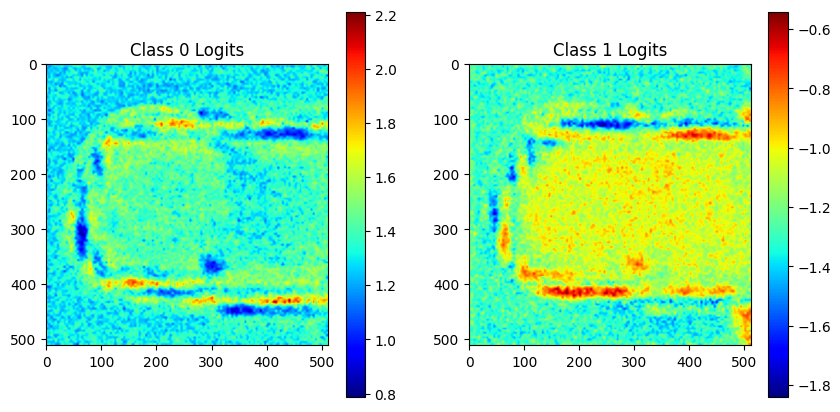

predicted logits dims: torch.Size([1, 2, 512, 512])
Predicted mask: min=0, max=0
Predicted mask unique values: tensor([0], device='cuda:0')


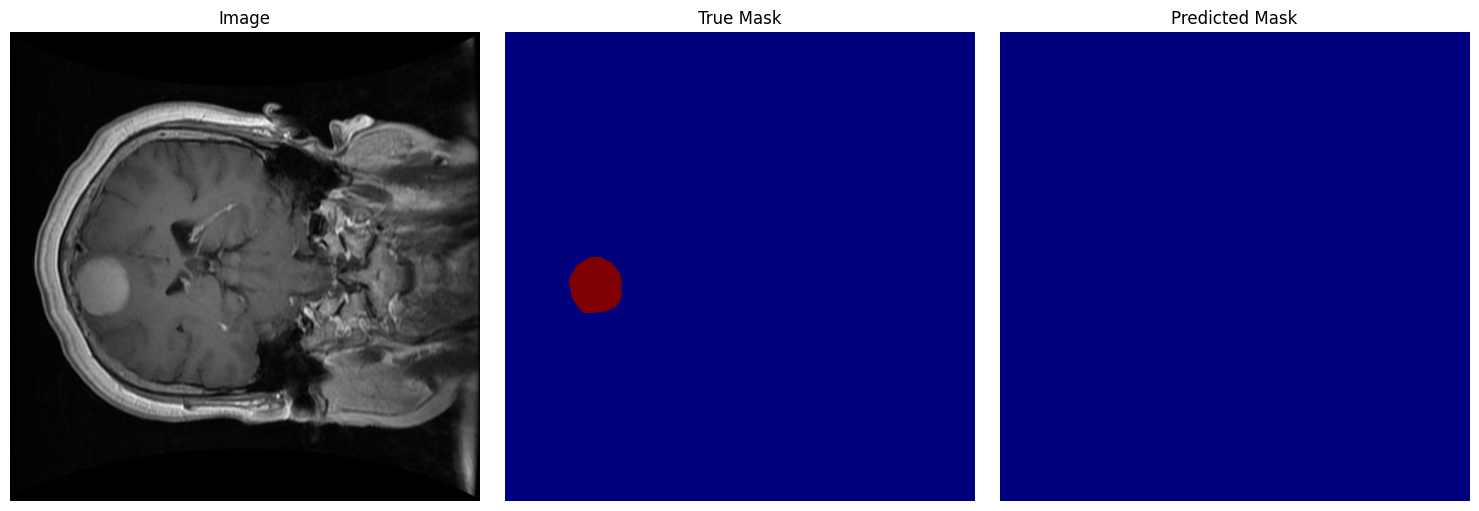

In [37]:
for batch in val_loader:
    break  # Get only the first batch

# Get the image and true mask from the batch
image = batch['pixel_values'][0].to(device)  # Move image to device
true_mask = batch['mask'][0].squeeze(0).to(device)  # Move mask to device and squeeze if necessary

# debug create_mask(pred_logits, target_size) by plotting the image, true_mask and predicted mask after call create_mask()
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image.unsqueeze(0))  # Add batch dimension for single image
    predicted_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])  # Get predicted mask

display_image_and_masks(image.cpu(), true_mask.cpu(), predicted_mask.cpu())
